In [14]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings; warnings.simplefilter('ignore')

In [15]:
file = pd.read_csv('results-survey150419.csv')
print("The total number of responses received is {}.\n".format(len(file)))
file = file.drop(file.columns[[range(0,6)]], axis=1)
file.rename(columns={file.columns[0]: 'Country', file.columns[1]: 'Business Category'\
                   , file.columns[2]: 'Business Category [Business Category - Other]'\
                   , file.columns[12]: 'Campaign Run'}, inplace=True)
file['Country'].replace(np.nan, "Other", inplace=True)

The total number of responses received is 243.



In [16]:
#Elimate respondents with no single measurement answer.
df = file
df.dropna(subset=['Campaign Run'], inplace=True)
print("First Cleaning: Elimating responses with no single measurement answer")
print("Total Number of responses: {}".format(len(df)))
print("Number of countries that responded: {}".format(len(df['Country'].value_counts())-1))#minus 1 of 'Other'
print("Responses with no country specified: {}\n".format(len(df[df['Country'] == "Other"])))

#Dropping all responses with less than 80% completion rate
df = df.dropna(thresh=df.shape[1]-80) #drop rows where NaN values constituate up to 92 of the total entries
print("Second Cleaning: Eliminate respondents with less than 80% completion")
total_responses = len(df)
print("Total Number of responses: {}".format(total_responses))
print("Number of countries that responded: {}".format(len(df['Country'].value_counts())-1))#minus 1 of 'Other'
print("Responses with no country specified: {}\n".format(len(df[df['Country'] == "Other"])))

#Excluded entries
#excluded_df = file[~file.index.isin(df.index)]
#excluded_df.to_csv(r'excluded.csv')

#Businesses that run measurement campaign
runm = len(df[['Business Category', 'Campaign Run']][df['Campaign Run']=="Yes"])
runperc = round(runm/len(df)*100, 2)
print("Total number of businesses than run some measurement campaign: {} or {}% of all responses"\
      .format(runm, runperc))

#Businesses that collect some measurement data
df.rename(columns={'8._Do_you_collect_data_for_the_metrics_selected_in_the_previous_question?\n\t\n\n\n\t\xa0':\
                   'Businesses Collecting Data'}, inplace=True)
mdata = len(df[['Business Category', 'Businesses Collecting Data']][df['Businesses Collecting Data']=="Yes"])
mdataper = round(mdata/len(df)*100, 2)
print("Total number of businesses that collect some measurement data: {} or {}% of all responses"\
      .format(mdata, mdataper))
#df['Business Category'].unique()

#Creating list of business and saving in dictionary for later use
list1 = list(file['Business Category'].unique())
dic = {k: v for v, k in enumerate(list1)}\
.fromkeys(list1, 0) #Create dictionary from the list, assign 0 as value of keys
businessList = pd.DataFrame.from_dict(dic, orient='index', columns=['Campaign Run'])

First Cleaning: Elimating responses with no single measurement answer
Total Number of responses: 162
Number of countries that responded: 35
Responses with no country specified: 10

Second Cleaning: Eliminate respondents with less than 80% completion
Total Number of responses: 123
Number of countries that responded: 34
Responses with no country specified: 4

Total number of businesses than run some measurement campaign: 31 or 25.2% of all responses
Total number of businesses that collect some measurement data: 68 or 55.28% of all responses


In [17]:
#Grouping businesses
def group_business(busdf, colname):
    if 'Business Category' != colname:
        #merging two groups to ISP
        ispsum = busdf.loc['Telecom (Mobile) Operator'] + busdf.loc['Wireless network'] 
        busdf.loc['Internet Service Provider (ISP)'] += ispsum
        
        #merging to academic Networks
        busdf.loc['Academic Institution'] += busdf.loc['Academic network (NRENs)'] 
        
        #Adding all to 'Other'
        if busdf.index.contains('Cable Operator'):
            grouped = busdf.loc['Community Network'] + busdf.loc['Enterprise Network'] \
            + busdf.loc['ccTLD/DNS Operator'] + busdf.loc['Datacentre'] + busdf.loc['Cable Operator']
            #Removing categories after merging to main groups
            busdf.drop(['Academic network (NRENs)', 'Telecom (Mobile) Operator', 'Enterprise Network',
                        'Cable Operator', 'Community Network', 'ccTLD/DNS Operator', 'Wireless network',
                        'Datacentre'], inplace=True)
        else:
            grouped = busdf.loc['Community Network'] + busdf.loc['Enterprise Network'] \
            + busdf.loc['ccTLD/DNS Operator'] + busdf.loc['Datacentre']
            #Removing categories after merging to main groups
            busdf.drop(['Academic network (NRENs)', 'Telecom (Mobile) Operator', 'Enterprise Network',
                        'Community Network', 'ccTLD/DNS Operator', 'Wireless network', 'Datacentre'],
                       inplace=True)
        busdf.loc['Other'] += grouped
        
    else:
        busdf = busdf[colname].value_counts()
        #merging two groups to ISP
        ispsum = busdf.loc['Telecom (Mobile) Operator'] + busdf.loc['Wireless network'] 
        busdf.loc['Internet Service Provider (ISP)'] += ispsum
        
        #merging to academic institutions
        busdf.loc['Academic Institution'] += busdf.loc['Academic network (NRENs)'] 
        
        #Adding all to 'Other'
        grouped = busdf.loc['Community Network'] + busdf.loc['Enterprise Network'] \
        + busdf.loc['ccTLD/DNS Operator'] + busdf.loc['Datacentre'] 
        busdf.loc['Other'] += grouped
        
        #Removing categories after merging to main groups
        busdf.drop(['Academic network (NRENs)', 'Telecom (Mobile) Operator', 'Enterprise Network',
                    'Community Network', 'ccTLD/DNS Operator', 'Wireless network',
                    'Datacentre'], inplace=True)
    return busdf

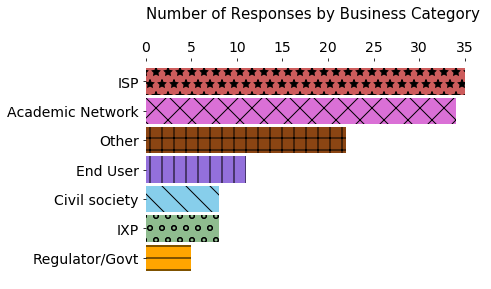

,Total Number of Responses,Number Running Campaign,% Running Campaign
ISP,35,7,20.00
Academic Network,34,7,20.59
Other,22,7,31.82
End User,11,4,36.36
Civil society,8,5,62.50
IXP,8,1,12.50
Regulator/Govt,5,0,0.00


In [21]:
#Number of responses by business category; and whether they run measurement campaign
def measurement_campaign():
    runcamp = df[['Business Category', 'Campaign Run']][df['Campaign Run']=="Yes"]
    runcamp = runcamp.groupby('Business Category').agg({'Campaign Run': 'count'})
    runcamp1 = pd.concat([runcamp, businessList], axis=0, join='inner')
    runcamp1 = runcamp1.groupby(level=0).sum()
    groupBus = group_business(runcamp1, 'Campaign Run')
    
    runCount = group_business(df, 'Business Category')
    final = pd.concat([runCount, groupBus], axis=1, join='outer')
    final.fillna(0, inplace=True)
    final['Campaign Run'] = final['Campaign Run'].astype(int)
    final['% Running Campaign'] = round((final['Campaign Run']/final['Business Category'])*100, 2)
    
    final.rename(columns={'Business Category': 'Total Number of Responses',
                          'Campaign Run':'Number Running Campaign'}, inplace=True)
    final = final.sort_values(by = ['Total Number of Responses'], ascending=False)
    final.rename(index={'End-user (Home/Mobile broadband)':'End User',
                     'Internet Service Provider (ISP)':'ISP',
                     'Internet eXchange Point (IXP)':'IXP',
                     'Academic Institution': 'Academic Network',
                     'Regulator/Government Agency':'Regulator/Govt'},inplace=True)
    final_plot = final['Total Number of Responses']
    final_plot = final_plot.iloc[::-1] #Reversing the index to have the higher values on top
    '''fig, ax = plt.subplots(figsize=(6,3))
    patterns = [ 'o' , '\\' , '|' , '-' , '+' , 'x']
    color=['orange', 'darkseagreen', 'skyblue', 'mediumpurple', 'saddlebrown', 'orchid']
    
    bars = ax.barh(*zip(*final.items()), .89, color=color)
    for bar, pattern in zip(bars, patterns):
        bar.set_hatch(pattern)    '''
    
    patterns = ['-', 'o' , '\\' , '|' , '+' , 'x', '*']
    color=['orange', 'darkseagreen', 'skyblue', 'mediumpurple', 'saddlebrown', 'orchid', 'indianred']
    
    ax = final_plot.plot(kind='barh', width=.9, figsize=(6,4), color=color)
    bars = ax.patches
    for bar, pattern in zip(bars, patterns):
        bar.set_hatch(pattern)
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
    ax.set_xlabel('Number of Responses by Business Category\n', fontdict={'fontsize': 15})
    ax.set_xticks([0,5,10,15,20,25,30,35])
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    plt.savefig('figures/network_responses.pdf', bbox_inches = 'tight')
    plt.show()
    return final
measurement_campaign()

In [22]:
#Whether a business category has run some measurement or not
def measurement_data():
    mdata = df[['Business Category', 'Businesses Collecting Data']][df['Businesses Collecting Data']=="Yes"]
    mdata = mdata.groupby('Business Category').agg({'Businesses Collecting Data': 'count'})
    groupBus = group_business(mdata, 'Businesses Collecting Data')
    runCount = group_business(df, 'Business Category')
    final = pd.concat([runCount, groupBus], axis=1, join='outer')
    final.rename(index={'End-user (Home/Mobile broadband)':'End User',
                     'Internet Service Provider (ISP)':'ISP',
                     'Internet eXchange Point (IXP)':'IXP',
                     'Academic Institution': 'Academic Network',
                     'Regulator/Government Agency':'Regulator/Govt'},inplace=True)
    
    final['% Running Measurement'] = round((final['Businesses Collecting Data']/final['Business Category'])*100, 2)
    final = final.iloc[::-1] #Reversing the index to have the higher values on top
    final.rename(columns={'Business Category': 'Total Number of Responses',
                          'Businesses Collecting Data':'Number Running Measurement'}, inplace=True)
    final = final.sort_values(by = ['Total Number of Responses'], ascending=False)
    return final
measurement_data()

,Total Number of Responses,Number Running Measurement,% Running Measurement
ISP,35,24,68.57
Academic Network,34,14,41.18
Other,22,15,68.18
End User,11,3,27.27
IXP,8,4,50.00
Civil society,8,6,75.00
Regulator/Govt,5,2,40.00


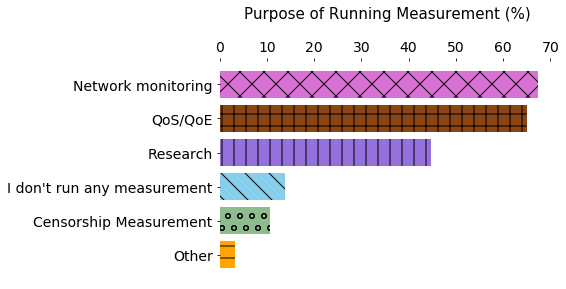

In [29]:
#Purpose of Running Business
def purpose_of_measurement():
    reasons =['Business Category',
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Network_monitoring]',
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Quality_of_Service_(QoS)/Quality_of_Experience_(QoE)]',
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Research]',
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Censorship_Measurement]',
              "6._Please_state_your_main_purpose_for_running_network_measurements?_[I_don't_run_any_measurement]",
              '6._Please_state_your_main_purpose_for_running_network_measurements?_[Other]']

    df2 = df[reasons]
    freq = []
    purpose = []
    other = 0
    for col in df2.columns[1:]:
        column = str(col)
        if col == "6._Please_state_your_main_purpose_for_running_network_measurements?_[Other]":
            new_purpose = tuple(df2[col].dropna().unique())
            for purp in new_purpose:
                value = len(df2[['Business Category', column]][df2[column]==str(purp)])
                other += value
            perc = (other/len(df2)*100)
            freq.append(perc)
            purpose.append("Other")
        else:    
            value = len(df2[['Business Category', column]][df2[column]=="Yes"])
            perc = (value/len(df2)*100)
            freq.append(perc)
            ntype = col.split('[')[1].split(']')[0]
            if ntype == "Quality_of_Service_(QoS)/Quality_of_Experience_(QoE)":
                ntype="QoS/QoE"
            purpose.append(ntype)
            
    final = dict(zip(purpose, freq)) #Creating dictionary based on the values in the two lists
    final = {k: v for k, v in sorted(final.items(), key=lambda x: x[1])} #Sorting dict by values

    fig, ax = plt.subplots(figsize=(6,4))
    patterns = [ '-', 'o' , '\\' , '|' , '+' , 'x',]
    color=['orange', 'darkseagreen', 'skyblue', 'mediumpurple', 'saddlebrown', 'orchid']
    
    final = {x.replace('_', ' '): v for x, v in final.items()}
    
    bars = plt.barh(*zip(*final.items()), height=.8, color=color)
    for bar, pattern in zip(bars, patterns):
        bar.set_hatch(pattern)
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
    ax.set_xlabel('Purpose of Running Measurement (%)\n', fontdict={'fontsize': 15})
    ax.set_xticks([0,10,20,30,40,50,60,70])
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    plt.savefig('figures/purpose.pdf', bbox_inches = 'tight')
    plt.show()

    return
purpose_of_measurement()


Which of these performance indicators/metrics are important for your organisation/network?




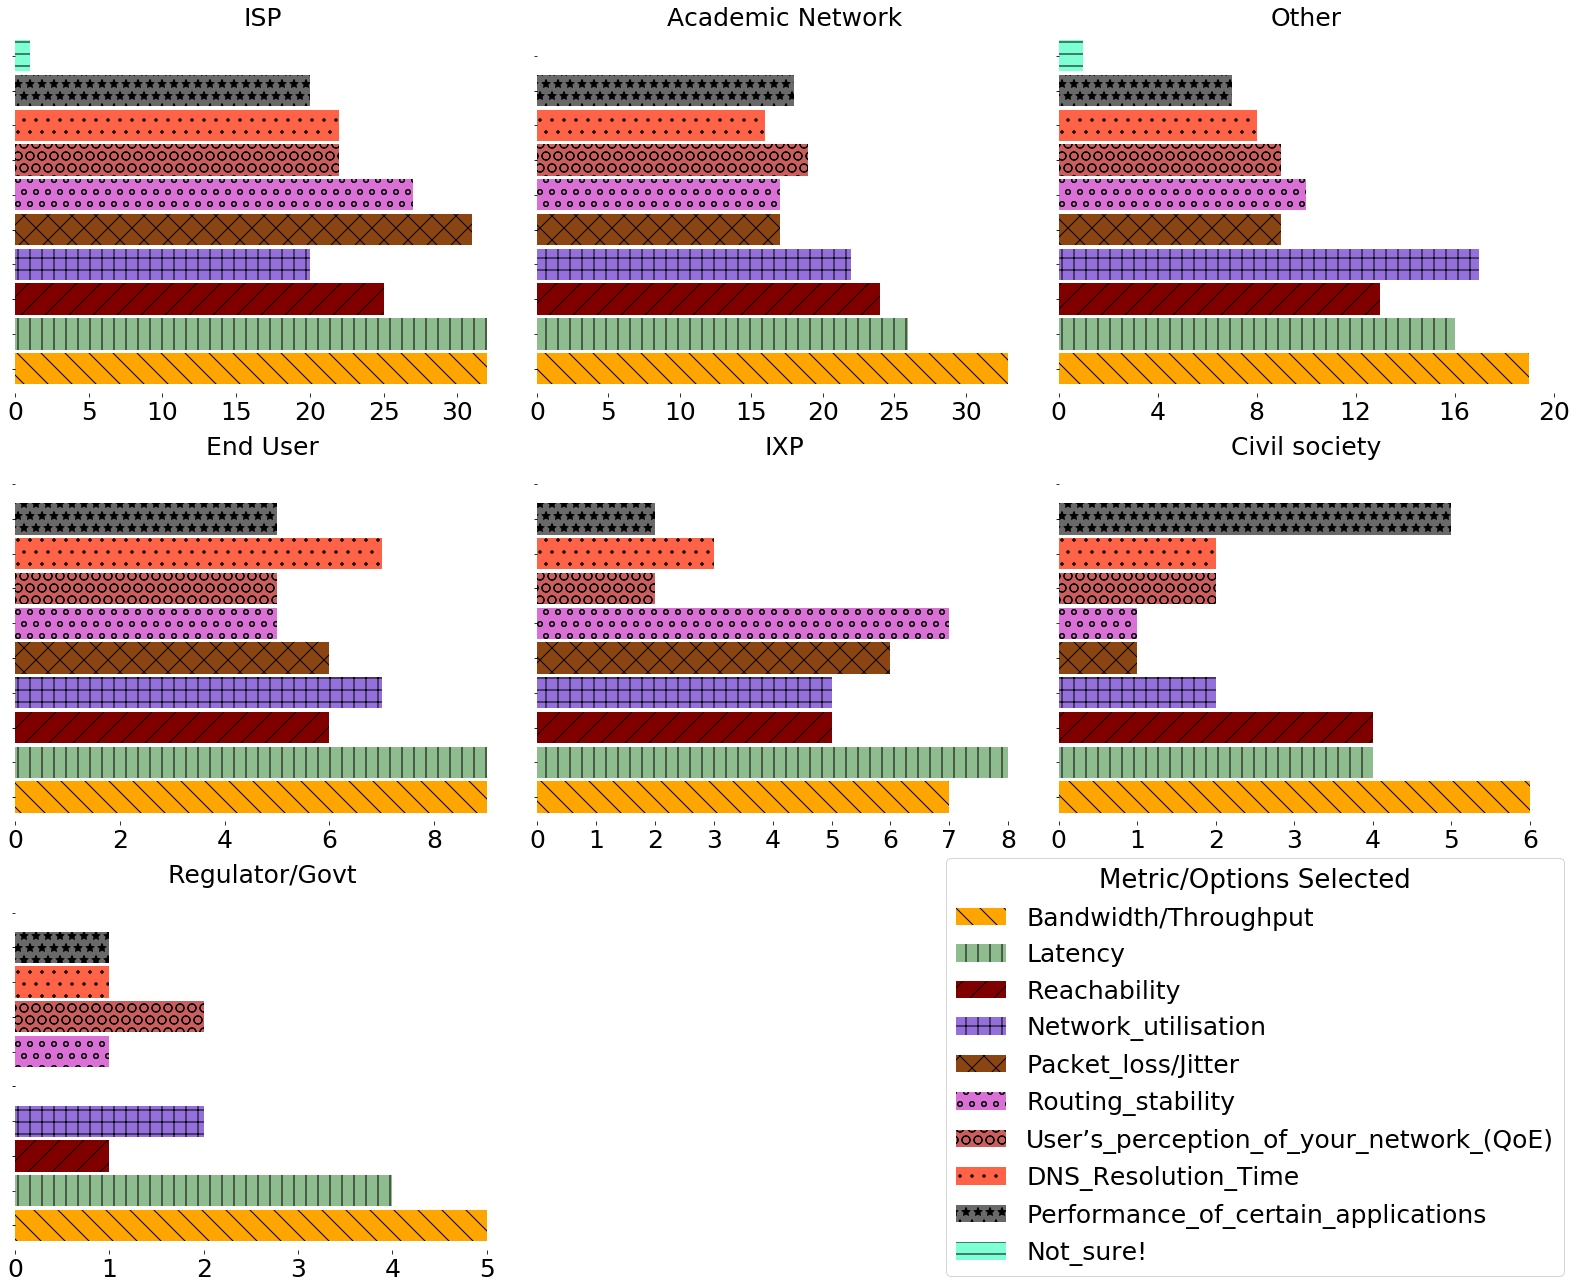

In [30]:
#The popular metrics
def metrics():
    metrics_list =['Business Category',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Latency]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Bandwidth/Throughput]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Packet_loss/Jitter]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[User’s_perception_of_your_network_(QoE)]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Reachability]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Routing_stability]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Performance_of_certain_applications_(Youtube,_Facebook,_etc)]]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Network_utilisation]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[DNS_Resolution_Time]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Not_sure!]',
 '7._Which_of_these_performance_indicators/metrics_are_important_for_your_organisation/network?_[Other]',]
    
    df1 = df[metrics_list]
    df1.replace(('Yes', 'No','Academic network (NRENs)', 'Telecom (Mobile) Operator','Wireless network',
                'Enterprise Network','ccTLD/DNS Operator','Community Network','Datacentre', 'Cable Operator'),
                (1, 0, 'Academic Institution', 'Internet Service Provider (ISP)',
                 'Internet Service Provider (ISP)', 'Other', 'Other', 'Other', 'Other', 'Other'), inplace=True)
    df1.set_index('Business Category', inplace=True)
    
    #Extract the required headings
    for col in df1.columns:
        name = col.split('[')[1].split(']')[0]
        if name == "Performance_of_certain_applications_(Youtube,_Facebook,_etc)":
            name=name.split("(")[0][:-1]
        df1.rename(columns={col:name}, inplace=True)
    
    df1.drop(['Other'], axis=1, inplace=True)
    '''df1['Other'] = df1['Other'].notnull().astype(int)
    df1.fillna(value={'Other':0}, inplace=True)'''
   
    df1 = df1.groupby(level=0, as_index=True).sum()
    
    df1.loc['Total',:]= df1.sum(axis=0)
    df1=df1[df1.iloc[-1,:].sort_values(ascending=False).index]
    df1['Total'] = df1.sum(axis=1)
    df1 = df1.sort_values(by='Total', ascending=False)
    
    i = j = roundcounter = 0
    patterns = ['\\', '|', '/', '+', 'x', 'o', 'O', '.', '*', '-']
    color=['orange', 'darkseagreen', 'maroon', 'mediumpurple', 'saddlebrown', 'orchid', 'indianred',
          'tomato', 'dimgrey', 'aquamarine'] 
    
    fig, axes = plt.subplots(3,3, sharex=False, sharey=True)
    print("\nWhich of these performance indicators/metrics are important for your organisation/network?\n\n")
    
    df1.rename(index={'End-user (Home/Mobile broadband)':'End User',
                     'Internet Service Provider (ISP)':'ISP',
                     'Internet eXchange Point (IXP)':'IXP',
                     'Academic Institution': 'Academic Network',
                     'Regulator/Government Agency':'Regulator/Govt'},inplace=True)

    #Plot the graphs
    for col in df1[1:].index:
        bars = df1.loc[col].drop(['Total']).plot.barh(width=.9, figsize=(22, 18), color=color, ax=axes[i, j])
        
        for tick in axes[i, j].xaxis.get_major_ticks():
                tick.label.set_fontsize(25)
        
        axes[i, j].set_title(df1.loc[col].name, fontdict={'fontsize': 25, 'fontweight': 'medium'})
        axes[i, j].get_yaxis().set_ticklabels([])
        for spine in axes[i, j].spines:
            axes[i, j].spines[spine].set_visible(False)

        for bar, pattern in zip(bars.patches, patterns):        
            bar.set_hatch(pattern)
        
        if j==2: 
            if roundcounter==0:
                roundcounter+=1
                i=1
                j=0
            elif roundcounter==1:
                roundcounter+=1
                j=0
                i=2
            elif roundcounter==2:
                i=2
                j=0
        elif j==1 or j==0:
                j+=1
        
    axes[0, 2].set_xticks([0, 4, 8, 12, 16, 20], minor=False)
    axes[2, 1].axis('off')
    axes[2, 2].axis('off')
    labels = df1.loc['Academic Network'].drop(['Total']).index.tolist()
    handles = [rect for rect in bars.get_children() if isinstance(rect, mpl.patches.Rectangle)]
    legend = fig.legend(handles, labels, loc=4, fontsize=25)
    legend.set_title('Metric/Options Selected',prop={'size':26})
    plt.savefig('figures/metrics.pdf', bbox_inches="tight")
    fig.tight_layout()

    plt.show()
    
    return 
metrics()

In [32]:
#Popular Platforms
def platforms():
    columns = ['Business Category',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[RIPE_Atlas]',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[MLAB/NDT]',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[Speedchecker]',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[CAIDA_Ark]',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[PerfSONAR]',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[Personal_Computer]',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[Bismark_Nodes]',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[N/A]',
               '9._What_tools_do_you_use_to_perform_the_measurement?\n\n\t\xa0_[Other]',]
    
    df1 = df[columns]
    df1.replace(('Yes', 'No','Academic network (NRENs)', 'Telecom (Mobile) Operator','Wireless network',
                'Enterprise Network','ccTLD/DNS Operator','Community Network','Datacentre', 'Cable Operator'),
                (1, 0, 'Academic Institution', 'Internet Service Provider (ISP)',
                 'Internet Service Provider (ISP)', 'Other', 'Other', 'Other', 'Other', 'Other'), inplace=True)
    df1.set_index('Business Category', inplace=True)
    
    #Extract the required headings
    for col in df1.columns:
        name = col.split('[')[1].split(']')[0]
        df1.rename(columns={col:name}, inplace=True)
  
    df1.drop(['Other'], axis=1, inplace=True)
    df1 = df1.groupby(level=0, as_index=True).sum()

    #Add Total for sorting purposes.
    df1.loc['Total',:]= df1.sum(axis=0)
    df1=df1[df1.iloc[-1,:].sort_values(ascending=False).index]
    df1['Total'] = df1.sum(axis=1)
    df1 = df1.sort_values(by='Total', ascending=False)
    
    
    cols = df1.columns.tolist()[:-1]
    sums = round((df1.loc['Total']/total_responses)*100, 2)
    #Calculate percentage for each value
    df1[cols] = round(df1[cols].div(df1[cols].drop(['Total']).sum(axis=0), axis = 1).multiply(100), 2)
    print("What_tools_do_you_use_to_perform_the_measurement?\n\nResults in Percentage".replace("_"," "))
    return df1.iloc[1:].append(sums).drop(['Total','N/A'], axis=1).fillna(0)#.to_latex()
platforms()

What tools do you use to perform the measurement?

Results in Percentage


,Personal_Computer,RIPE_Atlas,Speedchecker,PerfSONAR,CAIDA_Ark,MLAB/NDT,Bismark_Nodes
Business Category,,,,,,,
Academic Institution,25.49,28.57,26.92,70.00,37.5,33.33,0.0
Internet Service Provider (ISP),23.53,30.95,26.92,20.00,25.0,0.00,0.0
Other,27.45,14.29,15.38,0.00,0.0,33.33,0.0
End-user (Home/Mobile broadband),11.76,11.90,15.38,10.00,12.5,0.00,0.0
Civil society,3.92,4.76,7.69,0.00,0.0,33.33,0.0
Internet eXchange Point (IXP),3.92,9.52,3.85,0.00,25.0,0.00,0.0
Regulator/Government Agency,3.92,0.00,3.85,0.00,0.0,0.00,0.0
Total,41.46,34.15,21.14,8.13,6.5,2.44,0.0


Survey Question: Do you currently host any of these measurement infrastructures on your network?

Number of businesses not hosting any measurement probe: 65

Businesses hosting some measurement platform: 58


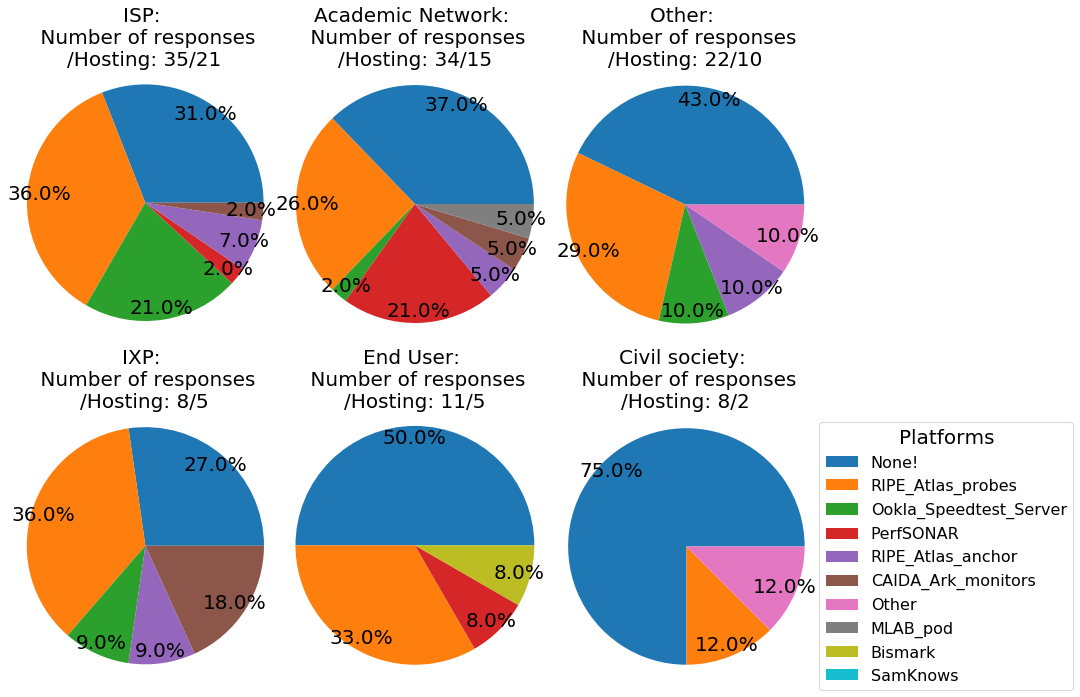

,None!,RIPE_Atlas_probes,Ookla_Speedtest_Server,PerfSONAR,RIPE_Atlas_anchor,CAIDA_Ark_monitors,Other,MLAB_pod,Bismark,SamKnows
Business Category,,,,,,,,,,
Academic Network,16,11,1,9,2,2,0,2,0,0
Other,9,6,2,0,2,0,2,0,0,0
IXP,3,4,1,0,1,2,0,0,0,0
End User,6,4,0,1,0,0,0,0,1,0
Civil society,6,1,0,0,0,0,1,0,0,0
Regulator/Govt,5,0,0,0,0,0,0,0,0,0
Total,58,41,13,11,8,5,3,2,1,0


In [41]:
#Hosting Platform Detail
import matplotlib.font_manager as font_manager
def hosting():
    columns = ['Business Category',
              '17._Do_you_currently_host_any_of_these_measurement_infrastructures_on_your_network?_[RIPE_Atlas_anchor]',
 '17._Do_you_currently_host_any_of_these_measurement_infrastructures_on_your_network?_[RIPE_Atlas_probes]',
 '17._Do_you_currently_host_any_of_these_measurement_infrastructures_on_your_network?_[MLAB_pod]',
 '17._Do_you_currently_host_any_of_these_measurement_infrastructures_on_your_network?_[Bismark]',
 '17._Do_you_currently_host_any_of_these_measurement_infrastructures_on_your_network?_[CAIDA_Ark_monitors]',
 '17._Do_you_currently_host_any_of_these_measurement_infrastructures_on_your_network?_[SamKnows]',
 '17._Do_you_currently_host_any_of_these_measurement_infrastructures_on_your_network?_[PerfSONAR]',
 '17._Do_you_currently_host_any_of_these_measurement_infrastructures_on_your_network?_[Ookla_Speedtest_Server]',
 '17._Do_you_currently_host_any_of_these_measurement_infrastructures_on_your_network?_[None!]',
 '17._Do_you_currently_host_any_of_these_measurement_infrastructures_on_your_network?_[Other]',]
    
    df1 = df[columns]
    df1.replace(('Yes', 'No','Academic network (NRENs)', 'Telecom (Mobile) Operator','Wireless network',
                'Enterprise Network','ccTLD/DNS Operator','Community Network','Datacentre', 'Cable Operator'),
                (1, 0, 'Academic Institution', 'Internet Service Provider (ISP)',
                 'Internet Service Provider (ISP)', 'Other', 'Other', 'Other', 'Other', 'Other'), inplace=True)
    df1.set_index('Business Category', inplace=True)
    df1.rename(index={'End-user (Home/Mobile broadband)':'End User',
                     'Internet Service Provider (ISP)':'ISP',
                     'Internet eXchange Point (IXP)':'IXP',
                     'Academic Institution': 'Academic Network',
                     'Regulator/Government Agency':'Regulator/Govt'},inplace=True)
    
    #Count of responses from different business categories
    count = {}
    for i in df1.index.unique().tolist():
        name = str(i)
        length = len(df1.loc[name])
        count.update({name:length })
    
    #Some dataframes for different operations
    ooni_probe = df1.loc[df1['17._Do_you_currently_host_any_of_these_measurement_infrastructures_on_your_network?_[Other]']\
                  == "OONI Probe"] #For a measurement platform not in the predefined categories
    
    #Changing values to 1 to simply count hosting or not hosting
    df1.replace(("Yes", "buil in applications", "build in apps", "OONI Probe"),
                  (1), inplace=True) 
    df1.replace(("No", "Not sure", "Not sure ", "not sure", "SNMP", "Which are no longer online - Did",
                   "solar winds", np.nan), (0), inplace=True)
    
    #Extract the required headings
    col_list = []
    for col in df1.columns:
        name = col.split('[')[1].split(']')[0]
        if name != 'None!': 
            col_list.append(name) #Removing None! column from the list
        df1.rename(columns={col:name}, inplace=True)
    
    #Rows that are all zero means the respondent did, either, not answered the question or
    #have selected None. Both options mean they are not hosting a probe.
    hosting = df1[col_list]
    hosting = hosting.loc[(hosting!=0).any(axis=1)] #rows that are not all zero entries
    not_hosting = len(df1) - len(hosting) 
    print("Survey Question: Do_you_currently_host_any_of_these_measurement_infrastructures_on_your_network?\n"\
          .replace("_"," "))
    print("Number of businesses not hosting any measurement probe: {}".format(not_hosting))
    number = {}
    for i in hosting.index.unique().tolist():
        name = str(i)
        length = len(hosting.loc[name])
        number.update({name:length })
    print('\nBusinesses hosting some measurement platform: {}'.format(len(hosting)))
    
    #Preparing data for plot/table
    df1 = df1.groupby(level=0, as_index=True).sum()
    
    #Add Total for sorting purposes.
    df1.loc['Total',:]= df1.sum(axis=0)
    df1=df1[df1.iloc[-1,:].sort_values(ascending=False).index]
    df1['Total'] = df1.drop(['None!'], axis=1).sum(axis=1)
    df1 = df1.sort_values(by='Total', ascending=False)
    sums = df1.loc['Total']
    df1 = df1[1:].drop(['Total'], axis=1)
    
    #print("Do_you_currently_host_any_of_these_measurement_infrastructures_on_your_network?\n".replace("_"," "))
    

    #colors=['orange', 'darkseagreen', 'maroon', 'mediumpurple', 'saddlebrown', 'orchid', 'indianred',
     #     'tomato', 'dimgrey', 'aquamarine'] 
    
    fig = plt.figure(figsize=(15,10))
    #colors = plt.cm.gray(np.linspace(0,1,10))
    #plt.rcParams['axes.prop_cycle'] = cycler(color=colors)    
    for i, (name, row) in enumerate(df1.drop(['Regulator/Govt']).iterrows()):
        #print(row)
        ax = plt.subplot(2,3, i+1)
        #ax[3, 1].axis('off')
        column = "'" + name + "'"
        if name == 'ISP':
            title =  "{}: \n Number of responses\n/Hosting: {}/{}"\
            .format(row.name, count[row.name], number[row.name])
            ax.set_title(title, fontsize=20)
        elif name == 'Academic Network':
            title = "{}: \n Number of responses\n/Hosting: {}/{}"\
            .format(row.name, count[row.name], number[row.name])
            ax.set_title(title, fontsize=20)
        elif name == 'IXP':
            title = "{}: \n Number of responses\n/Hosting: {}/{}"\
            .format(row.name, count[row.name], number[row.name])
            ax.set_title(title, fontsize=20)
        elif name == 'Civil society':
            title = "{}: \n Number of responses\n/Hosting: {}/{}"\
            .format(row.name, count[row.name], number[row.name])
            ax.set_title(title, fontsize=20)
        elif name == 'End User':
            title = "{}: \n Number of responses\n/Hosting: {}/{}"\
            .format(row.name, count[row.name], number[row.name])
            ax.set_title(title, fontsize=20)
        else:
            title = "{}: \n Number of responses\n/Hosting: {}/{}"\
            .format(row.name, count[row.name], number[row.name])
            ax.set_title(title, fontsize=20)
        ax.set_aspect('equal')
        pie = ax.pie(row, autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '', 
               pctdistance=0.9, labels=None, textprops={'fontsize': 20})
        #pie = ax.pie(row, autopct='%.1f', pctdistance=0.9,
               #labels=None, textprops={'fontsize': 20}, colors=colors)
        #centre_circle = plt.Circle((0,0),0.70,fc='white')
        #fig = plt.gcf()
        #fig.gca().add_artist(centre_circle)
        ax.axis('equal')#ensure that the pie is drawn as circle
    font = font_manager.FontProperties(size=16)
    #plt.legend(loc="best", labels=row.index, bbox_to_anchor=(1,1), prop=font)
    legend = plt.legend(loc="best", labels=row.index, bbox_to_anchor=(1,1), prop=font)
    legend.set_title('Platforms',prop={'size':20})
    plt.savefig('figures/hosting.jpg', bbox_inches="tight")
    plt.tight_layout()
    plt.show()
    df1 = df1.iloc[1:].append(sums[:-1]).astype(int)
    return df1
hosting()

In [42]:
#Privacy Laws
def privacy_laws():
    #Respondent with no idea about privacy laws
    number = len(df.loc[df['16._Are_there_privacy_laws_regulating_passive_network_measurement_in_your_country?']\
                  == "Not sure!"])
    percentage = round((number/total_responses)*100, 2)
    print("Respondent with no idea about privacy laws: {}%".format(percentage))
    return 
privacy_laws()
#df.columns.tolist()


Respondent with no idea about privacy laws: 52.85%
